# Keras - Deep Learning on Scenario A

Here, we will be applying deep neural networks in an to attempt to differentiate between Tor and nonTor data from the ISCXTor2016 dataset. 

In [1]:
# DataFrame handling
import pandas as pd

# Confusion matrix function
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# keras Models
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import CategoricalAccuracy, Precision, Recall

# sklearn Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Split data with stratified cv
from sklearn.model_selection import StratifiedKFold, train_test_split

# Encoding of classifications
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical, normalize

print('Imports complete.')

Imports complete.


Using TensorFlow backend.


In [2]:
# Set up a few constants to keep track of
random_state=1
path='../../tor_dataset/Scenario-A/'
dep_var = 'class'
num_classes=0

In [3]:
def getXy(filename='', dep_var='', verbose=0):
    """
        This function takes a filename, loads the data into a dataframe, then separates the classification data
        
        args:
            filename => str, path to csv file to be loaded
            
        returns:
            list(X,y) => data, classifications
    """
    df = pd.read_csv(filename)
    
    if verbose == 2:
        print('\tBefore encoding and splitting:')
        print(df.head())
    
    # Actual data
    #X = df.loc[:, df.columns != dep_var]
    X = pd.DataFrame()
    try:
        cols = ['min_fiat',
               'std_biat',
               'mean_biat',
               'max_biat']
        X = df[cols]
    except:
        cols = ['min_fiat',
               'total_biat',
               'mean_biat',
               'max_biat']
        X = df[cols]
        
    if verbose == 1 or verbose == 2:
        print('\n\tFeatures: {}'.format(X.columns))
        
    # Set number of classes we see
    num_classes = df[dep_var].nunique()
    
    # Classifications
    encoder = LabelEncoder()
    y = encoder.fit_transform(df[dep_var])
    
    if verbose == 2:
        print('\tClassification encoding:')
        for i in range(len(encoder.classes_)):
            print('\t{} => {}'.format(i, encoder.classes_[i]))
        
        print('\tAfter encoding and splitting:')
        print('\tX = ')
        print(X.head())
        print('\n\ty = ')
        print(y[:5])
    
    # X holds the data while y holds the classifications
    return X, y

In [4]:
def show_conf_matrix(model, X_test, y_test, names):
    # Techniques from https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
    # and https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix#51163585
    
    predictions = model.predict(X_test)
    matrix = [ [ 0 for j in range(len(predictions[0])) ]  for i in range(len(predictions[0])) ]
    for i in range(len(predictions)):
        pred = predictions[i]
        test = y_test[i]

        guess = np.argmax(pred)
        actual = np.argmax(test)

        matrix[actual][guess] += 1
        
    df_cm = pd.DataFrame(matrix, range(len(matrix)), range(len(matrix)))
    int_cols = df_cm.columns
    df_cm.columns = names
    df_cm.index = names

    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.5) # for label size
    ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=sn.color_palette("Blues")) # font size
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

    plt.show()
    
def create_dnn_model(metrics=['accuracy']):
    model = Sequential([
            Dense(64, input_shape=(4,)),
            Dense(32, activation='relu'),
            Dense(2, activation='softmax')
        ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
    
    return model

Training for TimeBasedFeatures-10s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.17	0.93	0.93	0.93

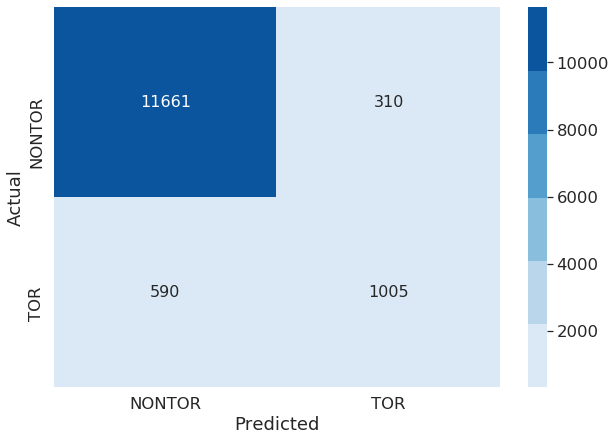

Training for TimeBasedFeatures-15s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.00	1.00	1.00	1.00

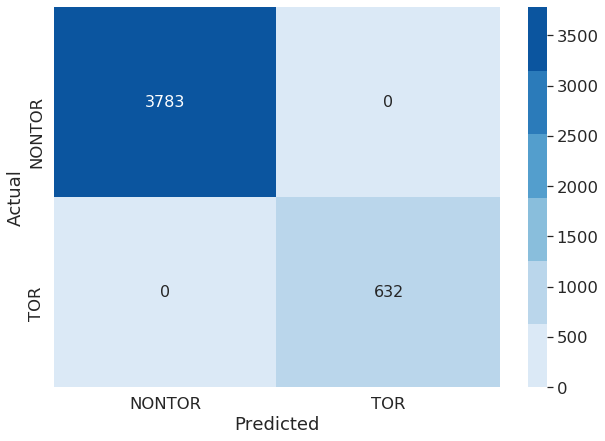

Training for TimeBasedFeatures-30s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.00	1.00	1.00	1.00

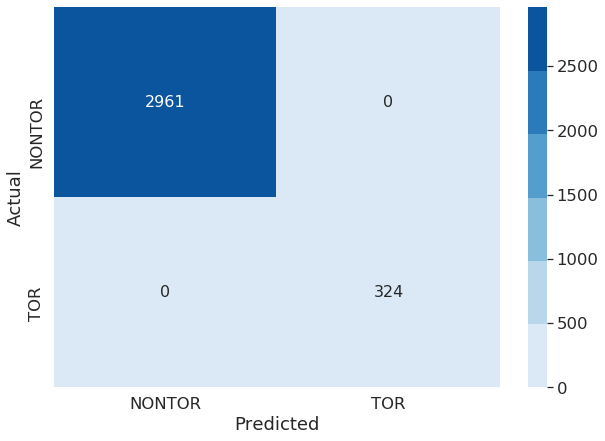

Training for TimeBasedFeatures-60s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.41	0.99	0.99	0.99

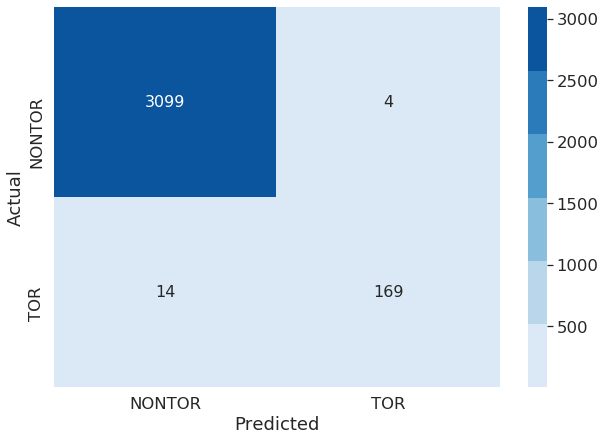

Training for TimeBasedFeatures-120s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.00	1.00	1.00	1.00

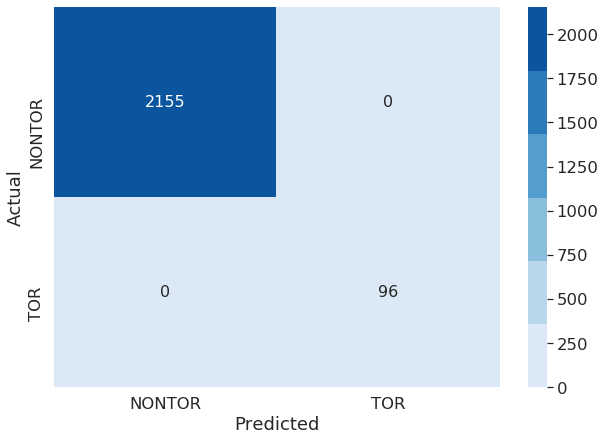

In [5]:
# Just run a DNN experiment
# All of the data files
files=['TimeBasedFeatures-10s-TOR-NonTOR.csv',
       'TimeBasedFeatures-15s-TOR-NonTOR.csv', 
       'TimeBasedFeatures-30s-TOR-NonTOR.csv', 
       'TimeBasedFeatures-60s-TOR-NonTOR.csv', 
       'TimeBasedFeatures-120s-TOR-NonTOR.csv']

# Gathered from the getXy function
#0 => NONTOR
#1 => TOR
names = ['NONTOR', 'TOR']

for file in files:
    print('Training for {}'.format(file), end='')
    X, y = getXy(path + file, dep_var, verbose=0)
    
    X = normalize(X)
    y = to_categorical(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Set up the metrics
    metrics = [
        CategoricalAccuracy(),
        Recall(),
        Precision()
    ]
    
    # Deep Neural Network
    dnn = create_dnn_model(metrics)
        
    dnn.fit(X_train, y_train, epochs=25, verbose=0)
    
    results = dnn.evaluate(X_test, y_test, verbose=0)
    
    print('\nMetrics:')
    print('\tLoss\tAcc\tRecall\tPrecision')
    for result in results:
        print('\t{:.2f}'.format(result), end='')
    
    # Show a confusion matrix
    show_conf_matrix(dnn, X_test, y_test, names)

In [6]:
from math import sqrt
def get_std(x=[], xbar=0):
    o2=0
    for xi in x:
        o2 += (xi - xbar)**2
    o2 /= len(x)-1
    return sqrt(o2)

In [7]:
# Lists for accuracies collected from models
list_dummy = []
list_dt = []
list_knn = []
list_dnn = []

std_dummy = []
std_dt = [] 
std_knn = []
std_dnn = []

# All of the data files
files=['TimeBasedFeatures-10s-TOR-NonTOR.csv',
       'TimeBasedFeatures-15s-TOR-NonTOR.csv', 
       'TimeBasedFeatures-30s-TOR-NonTOR.csv', 
       'TimeBasedFeatures-60s-TOR-NonTOR.csv', 
       'TimeBasedFeatures-120s-TOR-NonTOR.csv']

for file in files:
    print('Training for {}...'.format(file), end='')
    
    # Load in the data
    X, y = getXy(path + file, dep_var, verbose=1)
    
    # Mean accuracies for each model
    mean_dummy = 0 # This is the worst kind of dummy
    mean_dt = 0
    mean_knn = 0
    mean_dnn = 0
    
    # Keep to calculate std
    results_dummy = []
    results_dt = []
    results_knn = []  
    results_dnn = []
    
    # 10-fold Stratified Cross-Validation
    n_splits = 10
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idxs, test_idxs in skf.split(X, y):
        # Define the training and testing sets
        X_train, X_test = X.iloc[train_idxs], X.iloc[test_idxs]
        y_train, y_test = y[train_idxs], y[test_idxs]
        
        # Create a different version of the y_train and y_test for the Deep Neural Network
        y_train_dnn = to_categorical(y_train, num_classes=num_classes)
        y_test_dnn = to_categorical(y_test, num_classes=num_classes)
        
        # Initialize the sklearn models
        dummy = DummyClassifier(strategy='most_frequent')
        dt = DecisionTreeClassifier(random_state=random_state)
        knn = KNeighborsClassifier()
        
        # Deep Neural Network
        dnn = create_dnn_model()
        
        # Train the models
        dummy.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        dnn.fit(x=X_train, y=y_train_dnn, epochs=10, batch_size=20, verbose=0, validation_data=(X_test, y_test_dnn))
        
        # Evaluate the models
        results_dummy.append(dummy.score(X_test, y_test))
        results_dt.append(dt.score(X_test, y_test))
        results_knn.append(knn.score(X_test, y_test))  
        results_dnn.append( (dnn.evaluate(X_test, y_test_dnn, verbose=0) )[1] )
        
        #print(results_dummy[-1])
        #print(results_dt[-1])
        #print(results_knn[-1])
        #print(results_dnn[-1])
        
        # Add the results to the running mean
        mean_dummy += results_dummy[-1] / (n_splits * 1.0)
        mean_dt += results_dt[-1] / (n_splits * 1.0)
        mean_knn += results_knn[-1] / (n_splits * 1.0)
        mean_dnn += results_dnn[-1] / (n_splits * 1.0)
    
    # Push the mean results from all of the splits to the lists
    list_dummy.append(mean_dummy)
    list_dt.append(mean_dt)
    list_knn.append(mean_knn)
    list_dnn.append(mean_dnn)
    
    print('done')
    
    std_dummy.append(get_std(results_dummy, mean_dummy))
    std_dt.append(get_std(results_dt, mean_dt))
    std_knn.append(get_std(results_knn, mean_knn))
    std_dnn.append(get_std(results_dnn, mean_dnn))
    
print('All trainings complete!')

Training for TimeBasedFeatures-10s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'std_biat', 'mean_biat', 'max_biat'], dtype='object')
done
Training for TimeBasedFeatures-15s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'total_biat', 'mean_biat', 'max_biat'], dtype='object')
done
Training for TimeBasedFeatures-30s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'total_biat', 'mean_biat', 'max_biat'], dtype='object')
done
Training for TimeBasedFeatures-60s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'std_biat', 'mean_biat', 'max_biat'], dtype='object')
done
Training for TimeBasedFeatures-120s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'total_biat', 'mean_biat', 'max_biat'], dtype='object')
done
All trainings complete!


In [8]:
print(std_dummy)

[7.343153134443783e-05, 0.00021757917818890295, 0.00017524485488110432, 0.00031156775201348036, 1.5643923429016154e-05]


In [9]:
# Output results
print('File\tDummy\t\tDecision Tree\t\tk-Nearest Neighbor\t\tDeep Neural Network')
print('-'*99)
for i in range(len(files)):
    print('{0}\t{1:.2f}\u00B1{2:.2f}%\t{3:.2f}\u00B1{4:.2f}%\t\t{5:.2f}\u00B1{6:.2f}%\t\t\t{7:.2f}\u00B1{8:.2f}%'.format(files[i][18:-15], 100*list_dummy[i], 100*std_dummy[i], 100*list_dt[i], 100*std_dt[i], 100*list_knn[i], 100*std_knn[i], 100*list_dnn[i], 100*std_dnn[i]))

File	Dummy		Decision Tree		k-Nearest Neighbor		Deep Neural Network
---------------------------------------------------------------------------------------------------
10s	88.14±0.01%	95.45±0.34%		95.14±0.32%			88.14±0.01%
15s	84.99±0.02%	99.91±0.06%		99.83±0.10%			99.97±0.04%
30s	89.22±0.02%	99.88±0.09%		99.87±0.07%			99.80±0.42%
60s	94.44±0.03%	99.94±0.05%		99.83±0.09%			95.50±2.20%
120s	95.82±0.00%	99.88±0.10%		99.92±0.11%			99.98±0.06%


Training for downsampled_TimeBasedFeatures-10s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.29	0.88	0.88	0.88

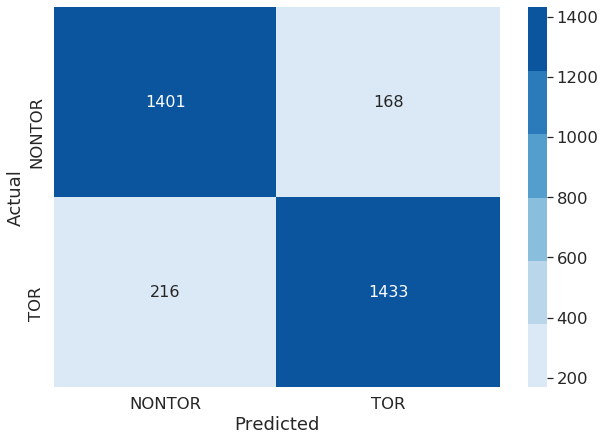

Training for downsampled_TimeBasedFeatures-15s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.00	1.00	1.00	1.00

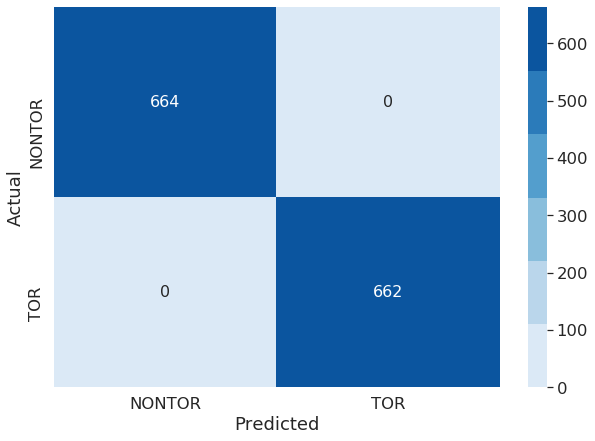

Training for downsampled_TimeBasedFeatures-30s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.00	1.00	1.00	1.00

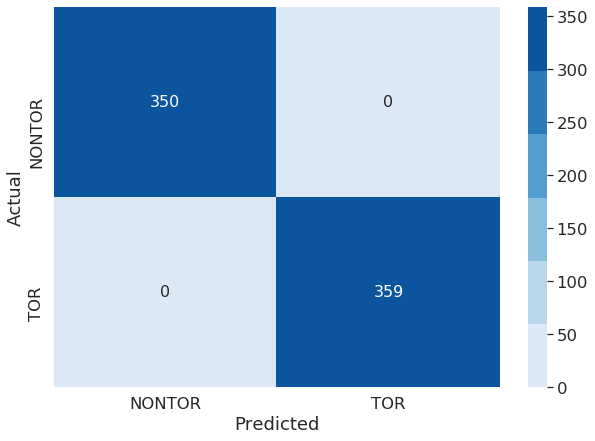

Training for downsampled_TimeBasedFeatures-60s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.21	0.92	0.92	0.92

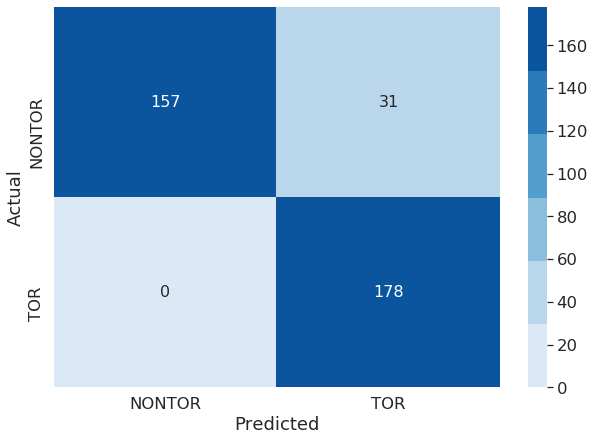

Training for downsampled_TimeBasedFeatures-120s-TOR-NonTOR.csv
Metrics:
	Loss	Acc	Recall	Precision
	0.01	0.99	0.99	0.99

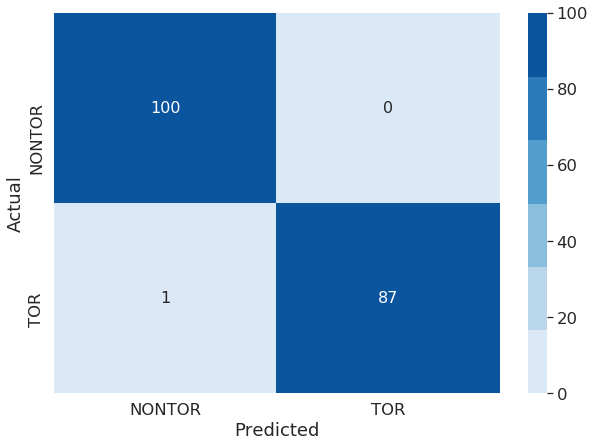

In [13]:
# Just run a DNN experiment
# All of the data files
files=['downsampled_TimeBasedFeatures-10s-TOR-NonTOR.csv',
       'downsampled_TimeBasedFeatures-15s-TOR-NonTOR.csv', 
       'downsampled_TimeBasedFeatures-30s-TOR-NonTOR.csv', 
       'downsampled_TimeBasedFeatures-60s-TOR-NonTOR.csv', 
       'downsampled_TimeBasedFeatures-120s-TOR-NonTOR.csv']

# Gathered from the getXy function
#0 => NONTOR
#1 => TOR
names = ['NONTOR', 'TOR']

for file in files:
    print('Training for {}'.format(file), end='')
    X, y = getXy(path + file, dep_var, verbose=0)
    
    X = normalize(X)
    y = to_categorical(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Set up the metrics
    metrics = [
        CategoricalAccuracy(),
        Recall(),
        Precision()
    ]
    
    # Deep Neural Network
    dnn = create_dnn_model(metrics)
        
    dnn.fit(X_train, y_train, epochs=25, verbose=0)
    
    results = dnn.evaluate(X_test, y_test, verbose=0)
    
    print('\nMetrics:')
    print('\tLoss\tAcc\tRecall\tPrecision')
    for result in results:
        print('\t{:.2f}'.format(result), end='')
    
    # Show a confusion matrix
    show_conf_matrix(dnn, X_test, y_test, names)

In [14]:
# Lists for accuracies collected from models
list_dummy = []
list_dt = []
list_knn = []
list_dnn = []

std_dummy = []
std_dt = [] 
std_knn = []
std_dnn = []

for file in files:
    print('Training for {}...'.format(file), end='')
    
    # Load in the data
    X, y = getXy(path + file, dep_var, verbose=1)
    
    # Mean accuracies for each model
    mean_dummy = 0 # This is the worst kind of dummy
    mean_dt = 0
    mean_knn = 0
    mean_dnn = 0
    
    # Keep to calculate std
    results_dummy = []
    results_dt = []
    results_knn = []  
    results_dnn = []
    
    # 10-fold Stratified Cross-Validation
    n_splits = 10
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idxs, test_idxs in skf.split(X, y):
        # Define the training and testing sets
        X_train, X_test = X.iloc[train_idxs], X.iloc[test_idxs]
        y_train, y_test = y[train_idxs], y[test_idxs]
        
        # Create a different version of the y_train and y_test for the Deep Neural Network
        y_train_dnn = to_categorical(y_train, num_classes=num_classes)
        y_test_dnn = to_categorical(y_test, num_classes=num_classes)
        
        # Initialize the sklearn models
        dummy = DummyClassifier(strategy='most_frequent')
        dt = DecisionTreeClassifier(random_state=random_state)
        knn = KNeighborsClassifier()
        
        # Deep Neural Network
        dnn = create_dnn_model()
        
        # Train the models
        dummy.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        dnn.fit(x=X_train, y=y_train_dnn, epochs=10, batch_size=20, verbose=0, validation_data=(X_test, y_test_dnn))
        
        # Evaluate the models
        results_dummy.append(dummy.score(X_test, y_test))
        results_dt.append(dt.score(X_test, y_test))
        results_knn.append(knn.score(X_test, y_test))  
        results_dnn.append( (dnn.evaluate(X_test, y_test_dnn, verbose=0) )[1] )
        
        #print(results_dummy[-1])
        #print(results_dt[-1])
        #print(results_knn[-1])
        #print(results_dnn[-1])
        
        # Add the results to the running mean
        mean_dummy += results_dummy[-1] / (n_splits * 1.0)
        mean_dt += results_dt[-1] / (n_splits * 1.0)
        mean_knn += results_knn[-1] / (n_splits * 1.0)
        mean_dnn += results_dnn[-1] / (n_splits * 1.0)
    
    # Push the mean results from all of the splits to the lists
    list_dummy.append(mean_dummy)
    list_dt.append(mean_dt)
    list_knn.append(mean_knn)
    list_dnn.append(mean_dnn)
    
    print('done')
    
    std_dummy.append(get_std(results_dummy, mean_dummy))
    std_dt.append(get_std(results_dt, mean_dt))
    std_knn.append(get_std(results_knn, mean_knn))
    std_dnn.append(get_std(results_dnn, mean_dnn))
    
print('All trainings complete!')

Training for downsampled_TimeBasedFeatures-10s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'std_biat', 'mean_biat', 'max_biat'], dtype='object')
done
Training for downsampled_TimeBasedFeatures-15s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'total_biat', 'mean_biat', 'max_biat'], dtype='object')
done
Training for downsampled_TimeBasedFeatures-30s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'total_biat', 'mean_biat', 'max_biat'], dtype='object')
done
Training for downsampled_TimeBasedFeatures-60s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'std_biat', 'mean_biat', 'max_biat'], dtype='object')
done
Training for downsampled_TimeBasedFeatures-120s-TOR-NonTOR.csv...
	Features: Index(['min_fiat', 'total_biat', 'mean_biat', 'max_biat'], dtype='object')
done
All trainings complete!


In [16]:
# Output results
print('File\tDummy\t\tDecision Tree\t\tk-Nearest Neighbor\t\tDeep Neural Network')
print('-'*99)
for i in range(len(files)):
    print('{0}\t{1:.2f}\u00B1{2:.2f}%\t{3:.2f}\u00B1{4:.2f}%\t\t{5:.2f}\u00B1{6:.2f}%\t\t\t{7:.2f}\u00B1{8:.2f}%'.format(files[i][30:-15], 100*list_dummy[i], 100*std_dummy[i], 100*list_dt[i], 100*std_dt[i], 100*list_knn[i], 100*std_knn[i], 100*list_dnn[i], 100*std_dnn[i]))

File	Dummy		Decision Tree		k-Nearest Neighbor		Deep Neural Network
---------------------------------------------------------------------------------------------------
10s	49.98±0.01%	91.27±0.43%		91.21±0.57%			80.58±7.87%
15s	49.94±0.03%	99.74±0.23%		99.55±0.25%			99.88±0.19%
30s	49.97±0.06%	99.60±0.36%		99.75±0.21%			99.46±0.71%
60s	49.78±0.12%	99.51±0.31%		98.96±0.79%			94.64±1.64%
120s	50.00±0.00%	99.47±0.90%		99.47±0.90%			99.36±0.74%
